In [ ]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8)

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

/root/miniconda3/lib/python3.12/site-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


In [ ]:
from rdkit import Chem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display


import sascorer # 用于计算 SAS

number of all smiles:  29978
number of successfully processed smiles:  29978
Data Description:
                 PCE
count  29978.000000
mean       3.900529
std        2.537518
min       -6.945400
25%        2.051324
50%        3.414248
75%        5.609893
max       11.086613
Missing values:
 smiles         0
PCE            0
cano_smiles    0
dtype: int64


/tmp/ipykernel_11987/1470832168.py:46: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(atom_num_dist, bins=28, kde=False)


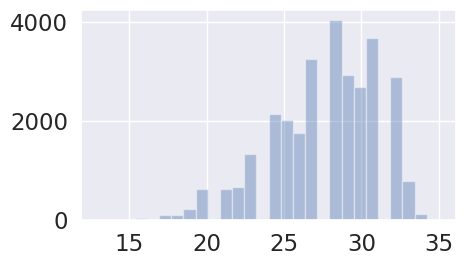

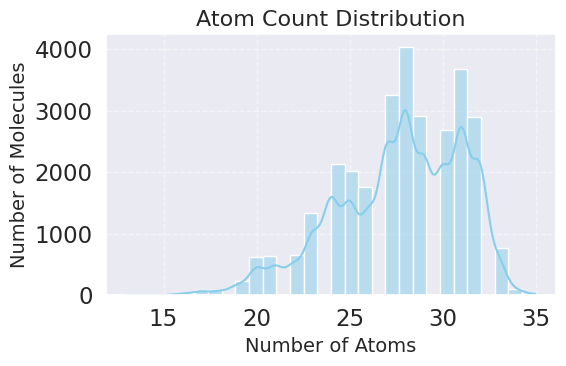

Longest molecule SMILES: [nH]1c2ccc3nsnc3c2c2c3cocc3c3cc(-c4nccc5nsnc45)c4cocc4c3c12
Shortest molecule SMILES: c1cnc(s1)-c1cc2sccc2s1


In [ ]:
task_name = 'Photovoltaic efficiency'
tasks = ['PCE']

raw_filename = "../data/cep-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')

# 加载数据，提取smiles列
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))


atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))


smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

# (fujun)基本统计信息展示
print("Data Description:\n", smiles_tasks_df.describe())
print("Missing values:\n", smiles_tasks_df.isnull().sum())



plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()

plt.show()
plt.close()

# (fujun)
plt.figure(figsize=(6, 4))
sns.histplot(atom_num_dist, bins=30, kde=True, color='skyblue')
plt.title("Atom Count Distribution", fontsize=16)
plt.xlabel("Number of Atoms", fontsize=14)
plt.ylabel("Number of Molecules", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# (fujun)
max_atoms_idx = np.argmax(atom_num_dist)
min_atoms_idx = np.argmin(atom_num_dist)
print("Longest molecule SMILES:", remained_smiles[max_atoms_idx])
print("Shortest molecule SMILES:", remained_smiles[min_atoms_idx])


In [ ]:
random_seed = 888
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 800

p_dropout= 0.15
fingerprint_dim = 200
weight_decay = 4.5 
learning_rate = 3.6

radius = 3
T = 1
# (fujun)参数可视化
print(f"""
===== Training Hyperparameters =====
Batch size         : {batch_size}
Epochs             : {epochs}
Learning Rate      : {learning_rate}
Weight Decay       : {weight_decay}
Dropout Prob       : {p_dropout}
Fingerprint Dim    : {fingerprint_dim}
Message Radius     : {radius}
Tasks              : {tasks}
Random Seed        : {random_seed}
====================================
""")

per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num


===== Training Hyperparameters =====
Batch size         : 200
Epochs             : 800
Learning Rate      : 3.6
Weight Decay       : 4.5
Dropout Prob       : 0.15
Fingerprint Dim    : 200
Message Radius     : 3
Tasks              : ['PCE']
Random Seed        : 888



In [ ]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)


# remained_df：图构建成功，后续用于训练; feature_dicts['smiles_to_atom_mask'].keys()：返回成功构建图的分子 canonical smiles
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]

uncovered_df = smiles_tasks_df.drop(remained_df.index)

In [15]:
uncovered_df

,smiles,PCE,cano_smiles


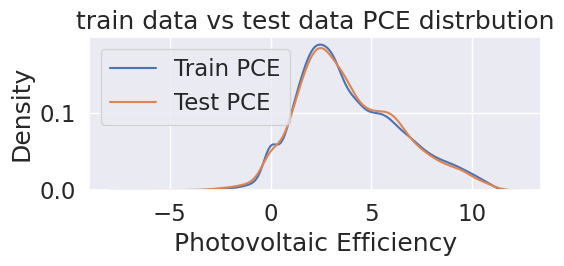

In [ ]:
test_df = remained_df.sample(frac=1/5,random_state=random_seed)

train_df = remained_df.drop(test_df.index)

# 重置索引
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# (fujun)训练集与测试集是否在 PCE（光伏效率）分布上 大致一致，以免模型在测试集上表现奇怪
plt.figure(figsize=(6, 3))
sns.kdeplot(train_df['PCE'], label='Train PCE')
sns.kdeplot(test_df['PCE'], label='Test PCE')
plt.xlabel('Photovoltaic Efficiency')
plt.legend()
plt.title('train data vs test data PCE distrbution')
plt.tight_layout()
plt.show()

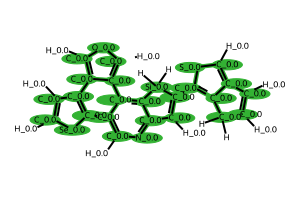

In [ ]:
# fujun
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.pyplot as plt
from IPython.display import SVG
import numpy as np

def visualize_smiles_graph(smiles, atom_mask=None, atom_features=None, figsize=(300, 200)):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    Chem.Kekulize(mol, clearAromaticFlags=True)
    rdDepictor.Compute2DCoords(mol)

    num_atoms = mol.GetNumAtoms()
    valid_len = min(len(atom_mask), num_atoms) if atom_mask is not None else num_atoms
    atom_indices = list(range(valid_len))

    highlight_atoms = []
    atom_colors = {}
    atom_labels = {}

    for idx in atom_indices:
        if atom_mask is not None and atom_mask[idx] == 1:
            highlight_atoms.append(idx)
            atom_colors[idx] = (0.2, 0.7, 0.2)
        elif atom_mask is not None:
            atom_colors[idx] = (0.7, 0.7, 0.7)

        if atom_features is not None:
            value = np.round(atom_features[idx], 2)
            atom_labels[idx] = f"{mol.GetAtomWithIdx(idx).GetSymbol()}_{value}"
        else:
            atom_labels[idx] = mol.GetAtomWithIdx(idx).GetSymbol()

    drawer = rdMolDraw2D.MolDraw2DSVG(figsize[0], figsize[1])
    opts = drawer.drawOptions()
    for i in atom_indices:
        opts.atomLabels[i] = atom_labels[i]
    drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg))


smiles = canonical_smiles_list[0]  
visualize_smiles_graph(smiles, atom_mask=x_mask[0], atom_features=x_atom[0][:, 0]) 

In [ ]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)

# 提取维度信息
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# 指数形式的学习率和权重衰减上面设置的 learning_rate = 3.6，会变成 1e-3.6 ≈ 2.51e-4;同样 weight_decay = 4.5 变成了 1e-4.5 ≈ 3.16e-5
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
# 
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

1145405
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
GRUCell.2.weight_ih torch.Size([600, 200])
GRUCell.2.weight_hh torch.Size([600, 200])
GRUCell.2.bias_ih torch.Size([600])
GRUCell.2.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 400])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
attend.2.weight torch.Size([200, 200]

In [ ]:
def train(model, dataset, optimizer, loss_function):
    model.train() # 设置模型为训练模式
    np.random.seed(epoch) # 设置随机种子
    valList = np.arange(0,dataset.shape[0]) # 获取数据集的索引
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size): # 按 batch_size 划分批次
        batch = valList[i:i+batch_size]
        batch_list.append(batch)
        
    for counter, batch in enumerate(batch_list): # 遍历每个 batch
        batch_df = dataset.loc[batch,:] # 获取当前 batch 的数据
        smiles_list = batch_df.cano_smiles.values # 获取 SMILES 字符串
        y_val = batch_df[tasks[0]].values # 获取目标值
        
        # 从 SMILES 获取图结构特征
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        
        # 预测
        atoms_prediction, mol_prediction = model(
            torch.Tensor(x_atom),
            torch.Tensor(x_bonds),
            torch.cuda.LongTensor(x_atom_index),
            torch.cuda.LongTensor(x_bond_index),
            torch.Tensor(x_mask)
        )
        
        optimizer.zero_grad() # 清空梯度
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1)) # 计算损失   
        loss.backward() # 反向传播
        optimizer.step() # 更新参数
        
def eval(model, dataset):
    model.eval() 
    test_MAE_list = []
    test_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values

        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')

        
        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()


0 18.77868 18.417952
1 4.144314 3.9638653
2 3.3902109 3.168722
3 2.6572924 2.4210348
4 2.7975187 2.5473497
5 2.485795 2.2627442
6 2.333979 2.1203303
7 2.4772403 2.26891
8 2.2713552 2.0513453
9 2.2044652 1.9790817
10 2.1971958 1.9669718
11 2.0784035 1.8599193
12 2.0114272 1.790541
13 2.0283577 1.818402
14 1.9413426 1.7341479
15 1.8914016 1.6811785
16 1.9429303 1.7325729
17 1.8237181 1.6150788
18 1.803662 1.6000602
19 1.8196932 1.6107825
20 1.7581432 1.5645944
21 1.75356 1.5423714
22 1.6740032 1.490812
23 1.6318047 1.4516191
24 1.6013128 1.427809
25 1.6395855 1.4476515
26 1.5714895 1.3933176
27 1.6182065 1.4307256
28 1.5232235 1.3439978
29 1.5167847 1.3514802
30 1.5254698 1.361767
31 1.4779829 1.3215669
32 1.4243791 1.26435
33 1.4016248 1.2437137
34 1.421617 1.2539147
35 1.457919 1.2809829
36 1.3550247 1.2238036
37 1.3376838 1.2094489
38 1.4722898 1.3380566
39 1.2932129 1.1522783
40 1.2297565 1.1248116
41 1.2163595 1.0996171
42 1.2424805 1.108375
43 1.2404459 1.1204553
44 1.2529354 1.128

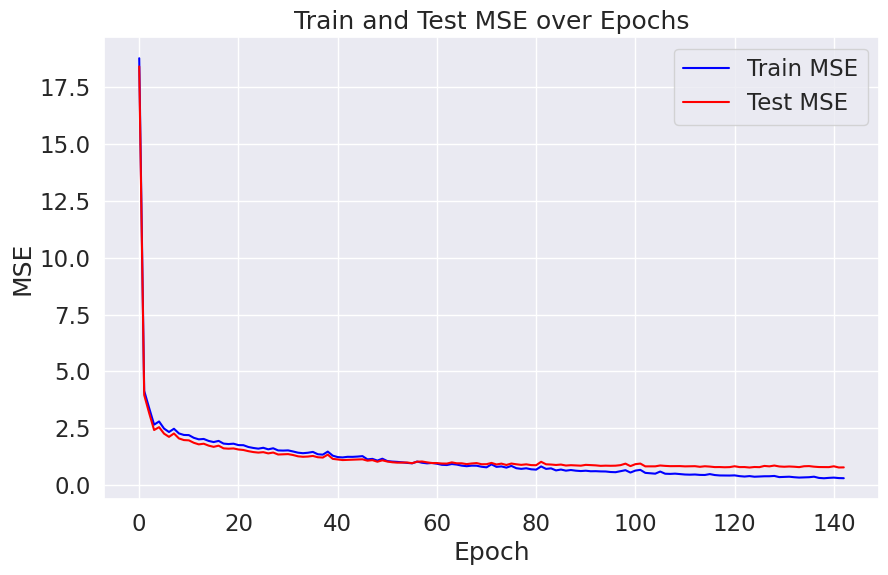

In [ ]:
best_param ={}
best_param["train_epoch"] = 0
best_param["test_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["test_MSE"] = 9e8

train_mse_values = []  
test_mse_values = []   

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    test_MAE, test_MSE = eval(model, test_df)

    train_mse_values.append(train_MSE)
    test_mse_values.append(test_MSE)

    

    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if test_MSE < best_param["test_MSE"]:
        best_param["test_epoch"] = epoch
        best_param["test_MSE"] = test_MSE
        if test_MSE < 0.9:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    
    if (epoch - best_param["train_epoch"] >2) and (epoch - best_param["test_epoch"] >18):        
        break
    print(epoch, train_MSE, test_MSE)
    

    train(model, train_df, optimizer, loss_function)
    

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_mse_values)), train_mse_values, label='Train MSE', color='blue')
plt.plot(range(len(test_mse_values)), test_mse_values, label='Test MSE', color='red')

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Train and Test MSE over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["test_epoch"])+'.pt')     

test_MAE, test_MSE = eval(best_model, test_df)
print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

best epoch: 123 
 test MSE: 0.7642773
